In [1]:
import pandas as pd
import numpy as np
import gsw
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as pltcolors

In [62]:
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
data = pd.read_csv("5906484qcno2PO4.txt",skiprows = 71, sep='\t',
    parse_dates = ['mon/day/yr'], na_values = [-10000000000.0])

data.columns

Index(['Cruise', 'Station', 'Type', 'mon/day/yr', 'hh:mm', 'Lon [°E]',
       'Lat [°N]', 'QF', 'Pressure[dbar]', 'QF.1', 'Temperature[°C]', 'QF.2',
       'Salinity[pss]', 'QF.3', 'Sigma_theta[kg/m^3]', 'QF.4', 'Depth[m]',
       'QF.5', 'Oxygen[µmol/kg]', 'QF.6', 'OxygenSat[%]', 'QF.7',
       'Nitrate[µmol/kg]', 'QF.8', 'Chl_a[mg/m^3]', 'QF.9', 'b_bp700[1/m]',
       'QF.10', 'POC[mmol/m^3]', 'QF.11', 'pHinsitu[Total]', 'QF.12',
       'pH25C[Total]', 'QF.13', 'TALK_LIAR[µmol/kg]', 'QF.14',
       'DIC_LIAR[µmol/kg]', 'QF.15', 'pCO2_LIAR[µatm]', 'QF.16',
       'Nitrite[µmol/kg]', 'QF.17', 'S2O3[µmol/kg]', 'QF.18',
       'PO4_CANY[µmol/kg]', 'QF.19', 'NO3_CANY[µmol/kg]', 'QF.20'],
      dtype='object')

In [4]:
data['QF.7'].value_counts()

0.0    4891
8.0      70
Name: QF.7, dtype: int64

In [5]:
data = pd.read_csv("5906484qcno2PO4.txt",skiprows = 71, sep='\t',
    parse_dates = ['mon/day/yr'], na_values = [-10000000000.0])

cols = {
    'Station': "station",
    'Lat [°N]': "lat",
    'Lon [°E]': "lon",
    'Pressure[dbar]': "press",
    'Temperature[°C]': "temperature",
    'QF.2':'temp_flag',
    'Salinity[pss]': "sal",
    'QF.3': "sal_flag",
    'Oxygen[µmol/kg]': "O2",
    'QF.6': "O2_flag",
    'Nitrate[µmol/kg]':"NO3",
    'QF.8':'NO3_flag',
    'Nitrite[µmol/kg]': "NO2",
    'QF.17': "NO2_flag",
    'PO4_CANY[µmol/kg]': "phosphate",
    'QF.19': "phosphate_flag",
    'pHinsitu[Total]': "pH_insitu",
    'QF.12': "pH_tot_flag",
    'TALK_LIAR[µmol/kg]':'TA',
    'QF.14':"TA_flag",
    'DIC_LIAR[µmol/kg]':'DIC',
    'QF.15':'DIC_flag'
}
data = data.rename(columns=cols)

# Select Flagged Bad Data

flag_good = np.array([0]) # 0 = good, 8 = bad
idx_flag = np.where(
    (np.isin(data["temp_flag"], flag_good))
    & (np.isin(data["sal_flag"], flag_good))
    & (np.isin(data["O2_flag"], flag_good))
    & (np.isin(data["NO3_flag"], flag_good))
    & (np.isin(data["phosphate_flag"], flag_good))
    & (np.isin(data["pH_tot_flag"], flag_good))
    & (np.isin(data["TA_flag"], flag_good))
    & (np.isin(data["NO2_flag"], flag_good))
)

data = data.iloc[idx_flag]

# Calculate Density
SA = gsw.SA_from_SP(data["sal"], data["press"], data["lon"], data["lat"])
CT = gsw.CT_from_t(SA, data["temperature"], data["press"])
data["sigma0"] = gsw.density.sigma0(SA, CT)
data["rho"] = gsw.density.rho(SA, CT, data["press"])

data["Nstar"] = ((data.NO2 + data.NO3) - 16 * data.phosphate + 2.9)

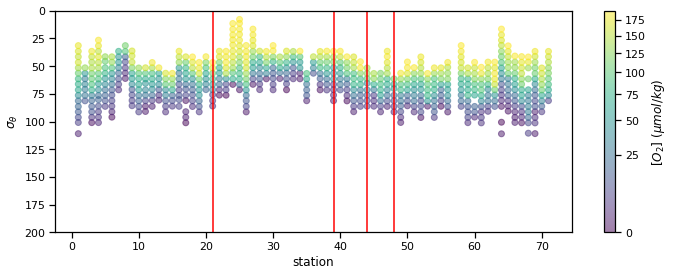

In [6]:
plotdf = data[(data['Depth[m]'] < 200) &
             (data.O2 > 2) &
             (data.O2 < 190)]

fig, ax = plt.subplots(1,1, figsize = (10,4))

cax = ax.scatter(plotdf['station'],
           #plotdf['sigma0'],
            plotdf['Depth[m]'],
                 alpha = 0.5,
           c = plotdf["O2"],
                norm=pltcolors.PowerNorm(gamma=0.5)
                )
cbar = fig.colorbar(cax).set_label('$[O_2]\ (\mu mol/kg$)')
#cax.set_clim([0,5])

#ax.set_ylim([28,20])
ax.set_ylim([200,0])

ax.axvline(21, color = "r")
ax.axvline(39, color = "r")
ax.axvline(44, color = "r")
ax.axvline(48, color = "r")

ax.set_xlabel("station")
ax.set_ylabel(r"$\sigma_{\theta}$")
plt.tight_layout()
plt.savefig("figures/oxycline.pdf")

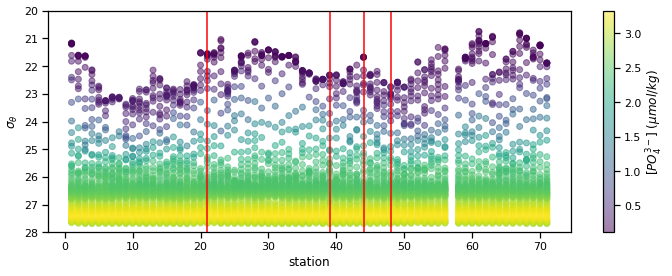

In [7]:
fig, ax = plt.subplots(1,1, figsize = (10,4))

cax = ax.scatter(data['station'],
           data['sigma0'],
            #data['Depth[m]'],
                 alpha = 0.5,
           c = data["phosphate"])
cbar = fig.colorbar(cax).set_label('$[PO_4^{3-}]\ (\mu mol/kg$)')
#cax.set_clim([0,4.0])

ax.set_ylim([28,20])
#ax.set_ylim([2000,0])

ax.axvline(21, color = "r")
ax.axvline(39, color = "r")
ax.axvline(44, color = "r")
ax.axvline(48, color = "r")

ax.set_xlabel("station")
ax.set_ylabel(r"$\sigma_{\theta}$")
plt.tight_layout()
plt.savefig("figures/po4section.pdf")

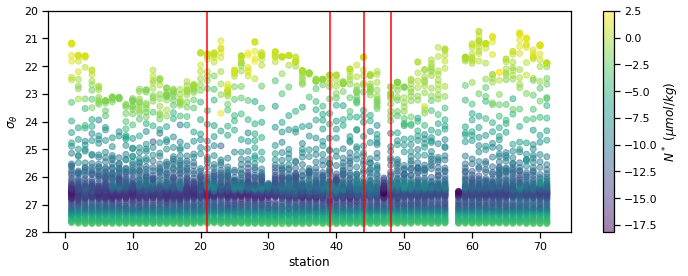

In [8]:
fig, ax = plt.subplots(1,1, figsize = (10,4))

cax = ax.scatter(data['station'],
           data['sigma0'],
            #data['Depth[m]'],
                 alpha = 0.5,
           c = data["Nstar"])
cbar = fig.colorbar(cax).set_label('$N^*\ (\mu mol/kg$)')
#cax.set_clim([0,4.0])

ax.set_ylim([28,20])
#ax.set_ylim([2000,0])

ax.axvline(21, color = "r")
ax.axvline(39, color = "r")
ax.axvline(44, color = "r")
ax.axvline(48, color = "r")

ax.set_xlabel("station")
ax.set_ylabel(r"$\sigma_{\theta}$")
plt.tight_layout()
plt.savefig("figures/N*section.pdf")

Text(0.5, 0, '$[NO_3^-]\\ (\\mu M)$')

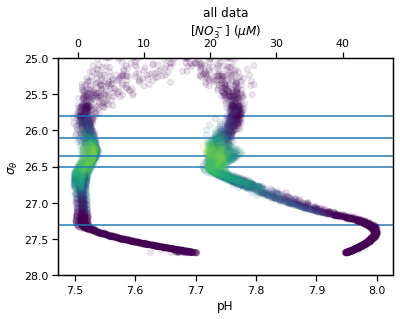

In [9]:
plotdf = data
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.8)
ax.axhline(26.1)
ax.axhline(26.35)
ax.axhline(26.5)
ax.axhline(27.3)

ax.set_ylim([28,25])
ax.set_title("all data")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

Text(0.5, 0, '$[NO_3^-]\\ (\\mu M)$')

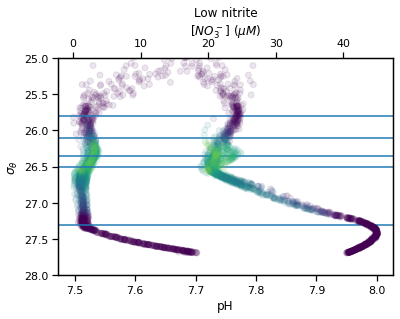

In [46]:
plotdf = data[data.station < 30]
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.8)
ax.axhline(26.1)
ax.axhline(26.35)
ax.axhline(26.5)
ax.axhline(27.3)

ax.set_ylim([28,25])
ax.set_title("Low nitrite")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

Text(0.5, 0, '$[NO_3^-]\\ (\\mu M)$')

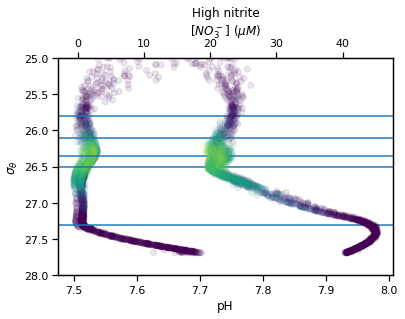

In [47]:
plotdf = data[data.station >= 30]
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.8)
ax.axhline(26.1)
ax.axhline(26.35)
ax.axhline(26.5)
ax.axhline(27.3)

ax.set_ylim([28,25])
ax.set_title("High nitrite")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

In [48]:
np.arange(1,30)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

25.369328573908753 26.804822111260375 27.68345193216147


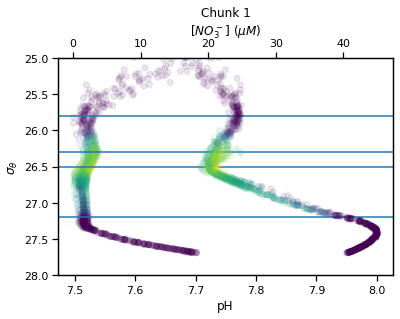

In [339]:
plotdf = data[
    (data.station>=1) &
    (data.station <= 21)]
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.8)
ax.axhline(26.3)
ax.axhline(26.5)
ax.axhline(27.2)

ax.set_ylim([28,25])
ax.set_title("Chunk 1")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

print(top, peak, bottom)

25.369328573908753 26.804822111260375 27.68345193216147


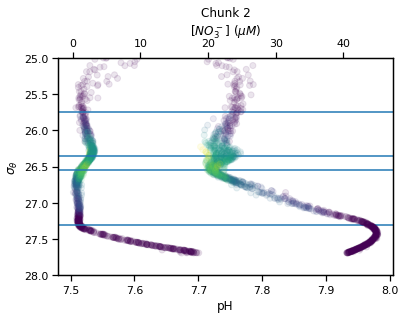

In [342]:
plotdf = data[
    (data.station>=21) &
    (data.station <= 40)]
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.75)
ax.axhline(26.35)
ax.axhline(26.55)
ax.axhline(27.3)

ax.set_ylim([28,25])
ax.set_title("Chunk 2")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

print(top, peak, bottom)

25.369328573908753 26.804822111260375 27.68345193216147


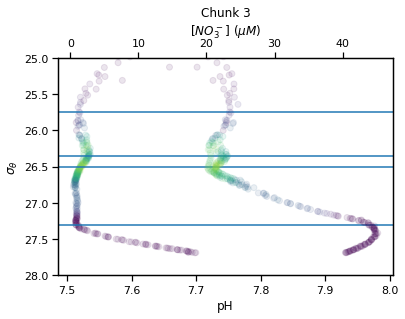

In [344]:
plotdf = data[
    (data.station>=40) &
    (data.station <= 44)]
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.75)
ax.axhline(26.35)
ax.axhline(26.5)
ax.axhline(27.3)

ax.set_ylim([28,25])
ax.set_title("Chunk 3")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

print(top, peak, bottom)

25.369328573908753 26.804822111260375 27.68345193216147


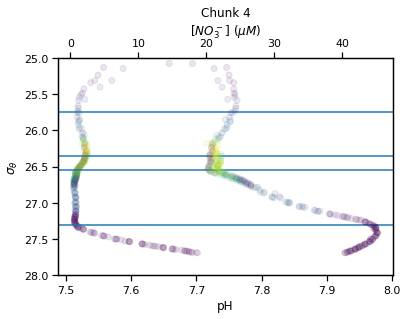

In [347]:
plotdf = data[
    (data.station>=44) &
    (data.station <= 48)]
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.75)
ax.axhline(26.35)
ax.axhline(26.55)
ax.axhline(27.3)

ax.set_ylim([28,25])
ax.set_title("Chunk 4")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

print(top, peak, bottom)

25.369328573908753 26.804822111260375 27.68345193216147


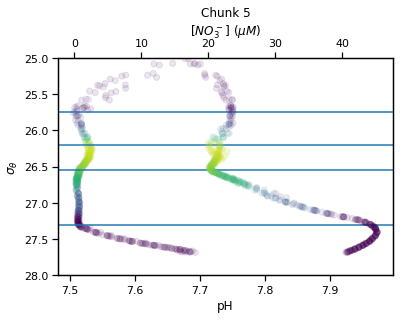

In [352]:
plotdf = data[
    (data.station>=48) &
    (data.station <= 57)]
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.75)
ax.axhline(26.2)
ax.axhline(26.55)
ax.axhline(27.3)

ax.set_ylim([28,25])
ax.set_title("Chunk 5")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

print(top, peak, bottom)

25.369328573908753 26.804822111260375 27.68345193216147


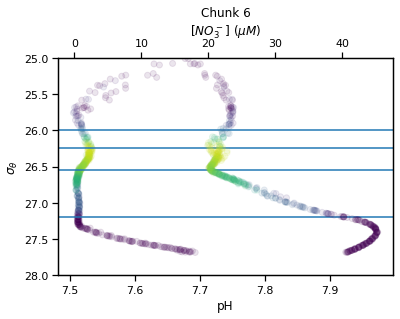

In [353]:
plotdf = data[
    (data.station>=48) &
    (data.station <= 57)]
    
fig, ax = plt.subplots()
ax.scatter(plotdf.pH_insitu, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax2 = ax.twiny()
ax2.scatter(plotdf.NO3, plotdf.sigma0,
          c = plotdf.NO2,
          alpha = 0.1)

ax.axhline(25.99)
ax.axhline(26.25)
ax.axhline(26.55)
ax.axhline(27.2)

ax.set_ylim([28,25])
ax.set_title("Chunk 6")
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel("pH")
ax2.set_xlabel(r"$[NO_3^-]\ (\mu M)$")

print(top, peak, bottom)

In [354]:
np.nan

nan

25.709047876169496 26.414928364619357 27.246425468122005


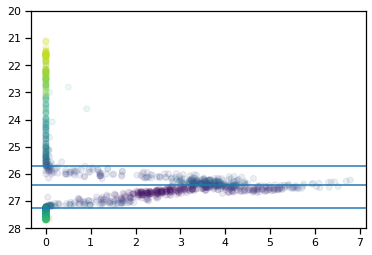

In [283]:
plotdf = data[
    (data.station>=21) &
    (data.station <= 40)]

tops = np.zeros((len(plotdf.station.drop_duplicates())))
bottoms = np.zeros((len(plotdf.station.drop_duplicates())))
peaks = np.zeros((len(plotdf.station.drop_duplicates())))

for i,s in enumerate(plotdf.station.drop_duplicates()):
    station = data[(data.station==s)&
                  (data.sigma0>25)]
    station = station[['sigma0', 'NO2']].dropna().sort_values("sigma0")
    sigma0 = np.array(station.sigma0)
    dx0 = sigma0[:-1]
    dx1 = sigma0[1:]
    dx = abs(dx0 - dx1)
    y = np.array(station.NO2)
    dy = diff(y)/dx
    
    snmidx = np.array(np.where(dy!=0))
    top = int(snmidx[:,0])
    bottom = int(snmidx[:,-1]) +1

    top = float(station.sigma0.iloc[top+1])
    bottom = float(station.sigma0.iloc[bottom])
    peak = float(station[station.NO2==station.NO2.max()].sigma0.iloc[0])
    
    tops[i] = top
    bottoms[i] = bottom
    peaks[i] = peak

peak = peaks.mean()
top = tops.mean()
bottom = bottoms.mean()
    
fig, ax = plt.subplots()
ax.scatter(plotdf.NO2, plotdf.sigma0,
          c = plotdf.Nstar,
          alpha = 0.1)

ax.axhline(top)
ax.axhline(peak)
ax.axhline(bottom)

ax.set_ylim([28,20])

print(top, peak, bottom)

1 2.9
2 3.47
3 3.94
4 4.06
5 3.43
6 3.55
7 3.54
8 3.88
9 3.93
10 3.28
11 3.8
12 3.81
13 3.59
14 3.93
15 3.61
16 3.66
17 3.48
18 3.37
19 3.06
20 4.1
21 3.35
22 4.33
23 3.67
24 3.85
25 3.33
26 3.67
27 4.5
28 5.22
29 3.96
30 6.79
31 5.58
32 5.55
33 5.57
34 5.74
35 4.92
36 5.51
37 5.26
38 5.35
39 5.65
40 6.52
41 5.24
42 5.0
43 5.09
44 5.5
45 5.39
46 5.54
47 2.1
48 5.58
49 5.53
50 5.57
51 5.58
52 5.72
53 5.77
54 5.44
55 5.48
56 5.92
58 4.22
59 5.4
60 5.05
61 5.1
62 5.32
63 5.22
64 5.06
65 5.33
66 5.55
67 5.74
68 5.57
69 5.71
70 5.08
71 5.19


(28.0, 20.0)

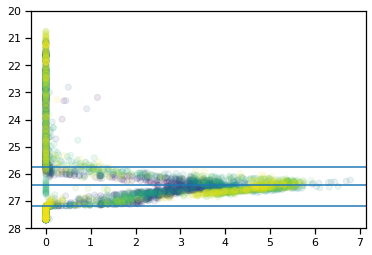

In [38]:
tops = np.zeros((len(data.station.drop_duplicates())))
bottoms = np.zeros((len(data.station.drop_duplicates())))
peaks = np.zeros((len(data.station.drop_duplicates())))
stations = np.zeros((len(data.station.drop_duplicates())))

for i,s in enumerate(data.station.drop_duplicates()):
    station = data[(data.station==s)&
                  (data.sigma0>25)]
    station = station[['sigma0', 'NO2']].dropna().sort_values("sigma0")
    sigma0 = np.array(station.sigma0)
    dx0 = sigma0[:-1]
    dx1 = sigma0[1:]
    dx = abs(dx0 - dx1)
    y = np.array(station.NO2)
    dy = np.diff(y)/dx
    
    snmidx = np.array(np.where(dy!=0))
    top = int(snmidx[:,0])
    bottom = int(snmidx[:,-1])

    top = float(station.sigma0.iloc[top+1])
    bottom = float(station.sigma0.iloc[bottom])
    peak = float(station[station.NO2==station.NO2.max()].sigma0.iloc[0])
    print(s,station.NO2.max())
    
    tops[i] = top
    bottoms[i] = bottom
    peaks[i] = peak
    stations[i] = s

peak = peaks.mean()
top = tops.mean()
bottom = bottoms.mean()
    
fig, ax = plt.subplots()
ax.scatter(data.NO2, data.sigma0,
          c = data.station,
          alpha = 0.1)

ax.axhline(top)
ax.axhline(peak)
ax.axhline(bottom)

ax.set_ylim([28,20])

#print(top, peak, bottom)

In [14]:
snmdf = pd.DataFrame([tops, peaks, bottoms]).T
snmdf = snmdf.rename(columns = {0:'top',
                               1:'peak',
                               2:'bottom'})
snmdf['station'] = stations
snmdf['toprolling'] = snmdf.top.rolling(window=5, center = True).mean()
snmdf['peakrolling'] = snmdf.peak.rolling(window=5, center = True).mean()
snmdf['bottomrolling'] = snmdf.bottom.rolling(window=5, center = True).mean()
snmdf

,top,peak,bottom,station,toprolling,peakrolling,bottomrolling
0,25.852952,26.565122,27.166632,1.0,NaN,NaN,NaN
1,25.785077,26.486152,27.151137,2.0,NaN,NaN,NaN
2,25.935442,26.534712,27.212297,3.0,25.910486,26.520764,27.178656
3,26.092901,26.471207,27.183595,4.0,25.943810,26.507398,27.187957
4,25.886058,26.546628,27.179618,5.0,25.928080,26.505812,27.193759
...,...,...,...,...,...,...,...
65,25.932660,26.424733,27.126114,67.0,25.662406,26.365975,27.152030
66,26.000378,26.334083,27.170060,68.0,25.690748,26.350967,27.150421
67,25.322178,26.286968,27.134156,69.0,25.652651,26.333115,27.144361
68,25.450141,26.254864,27.161429,70.0,NaN,NaN,NaN


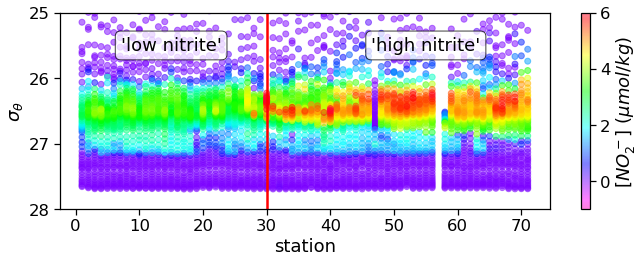

In [69]:
sorteddata = data.sort_values("NO2")

fig, ax = plt.subplots(1,1, figsize = (10,4))

cax = ax.scatter(sorteddata['station'],
           sorteddata['sigma0'],
            #sorteddata['Depth[m]'],
                 alpha = 0.5,
           c = sorteddata['NO2'],
                cmap = "gist_rainbow_r")
cax.set_clim([-1,6.0])
'''
ax.plot(snmdf.station, snmdf.toprolling,
       color = "k",
       linewidth = 3)
ax.plot(snmdf.station, snmdf.bottomrolling,
       color = "k",
       linewidth = 3)
'''

ax.text(15, 25.5, "'low nitrite'",
       verticalalignment = "center", horizontalalignment = "center",
       bbox = dict(facecolor='white', edgecolor='k',boxstyle='round',alpha=0.75))

ax.text(55, 25.5, "'high nitrite'",
       verticalalignment = "center", horizontalalignment = "center",
       bbox = dict(facecolor='white', edgecolor='k',boxstyle='round',alpha=0.75))

cbar = fig.colorbar(cax).set_label('$[NO_2^-]\ (\mu mol/kg$)')

ax.set_ylim([28,25])
#ax.set_ylim([2000,0])

#ax.set_xlim([40,50])

ax.axvline(30, color = "r")

ax.set_xlabel("station")
ax.set_ylabel(r"$\sigma_{\theta}$")
plt.tight_layout()
plt.savefig("figures/no2section.pdf")

In [71]:
data.columns

Index(['Cruise', 'station', 'Type', 'mon/day/yr', 'hh:mm', 'lon', 'lat', 'QF',
       'press', 'QF.1', 'temperature', 'temp_flag', 'sal', 'sal_flag',
       'Sigma_theta[kg/m^3]', 'QF.4', 'Depth[m]', 'QF.5', 'O2', 'O2_flag',
       'OxygenSat[%]', 'QF.7', 'NO3', 'NO3_flag', 'Chl_a[mg/m^3]', 'QF.9',
       'b_bp700[1/m]', 'QF.10', 'POC[mmol/m^3]', 'QF.11', 'pH_insitu',
       'pH_tot_flag', 'pH25C[Total]', 'QF.13', 'TA', 'TA_flag', 'DIC',
       'DIC_flag', 'pCO2_LIAR[µatm]', 'QF.16', 'NO2', 'NO2_flag',
       'S2O3[µmol/kg]', 'QF.18', 'phosphate', 'phosphate_flag',
       'NO3_CANY[µmol/kg]', 'QF.20', 'sigma0', 'rho', 'Nstar'],
      dtype='object')

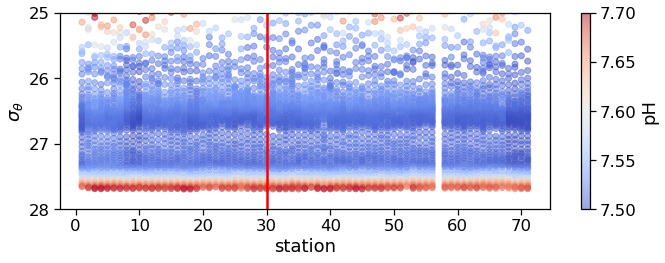

In [86]:
sorteddata = data.sort_values("pH_insitu")

fig, ax = plt.subplots(1,1, figsize = (10,4))

cax = ax.scatter(sorteddata['station'],
           sorteddata['sigma0'],
            #sorteddata['Depth[m]'],
                 alpha = 0.5,
           c = sorteddata['pH_insitu'],
                cmap = "coolwarm")
cax.set_clim([7.5,7.7])
'''
ax.plot(snmdf.station, snmdf.toprolling,
       color = "k",
       linewidth = 3)
ax.plot(snmdf.station, snmdf.bottomrolling,
       color = "k",
       linewidth = 3)
'''

cbar = fig.colorbar(cax).set_label('pH')

ax.set_ylim([28,25])
#ax.set_ylim([2000,0])

#ax.set_xlim([40,50])

ax.axvline(30, color = "r")

ax.set_xlabel("station")
ax.set_ylabel(r"$\sigma_{\theta}$")
plt.tight_layout()
plt.savefig("figures/phsection.pdf")

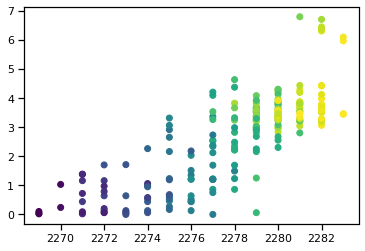

In [30]:
plotdf = data[
    (data.station>=21) &
    (data.station <= 40) &
    (data.sigma0 >= 25.75)&
             (data.sigma0 <= 26.35)]

plt.scatter(plotdf.DIC, plotdf.NO2,
           c = plotdf.sigma0)

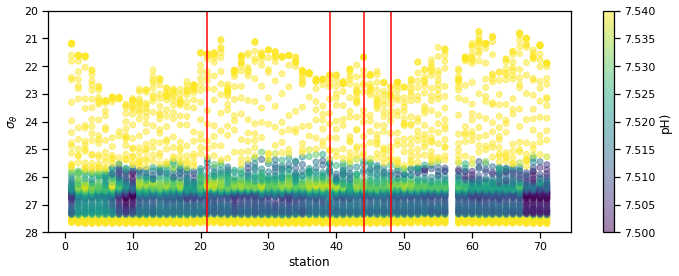

In [31]:
fig, ax = plt.subplots(1,1, figsize = (10,4))

cax = ax.scatter(data['station'],
           data['sigma0'],
            #data['Depth[m]'],
                 alpha = 0.5,
           c = data['pH_insitu'])
cbar = fig.colorbar(cax).set_label('pH)')
cax.set_clim([7.5,7.54])

ax.set_ylim([28,20])
#ax.set_ylim([2000,0])

ax.axvline(21, color = "r")
ax.axvline(39, color = "r")
ax.axvline(44, color = "r")
ax.axvline(48, color = "r")

ax.set_xlabel("station")
ax.set_ylabel(r"$\sigma_{\theta}$")
plt.tight_layout()
plt.savefig("figures/pHsection.pdf")

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_79301/3761498143.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize = (3,4))


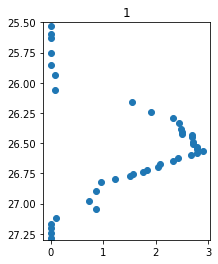

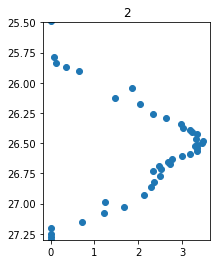

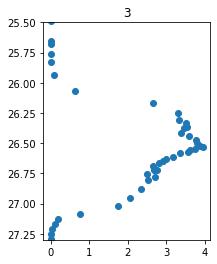

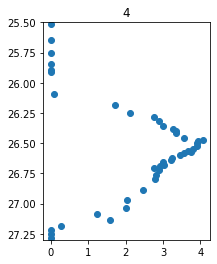

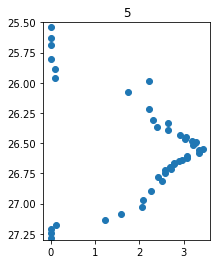

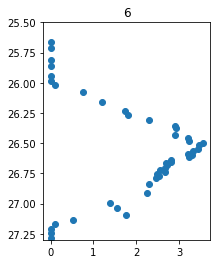

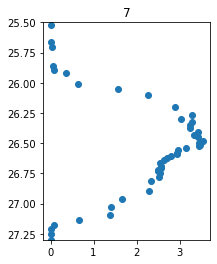

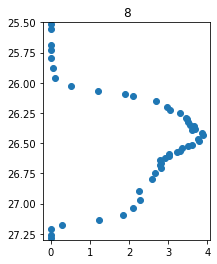

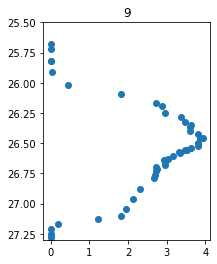

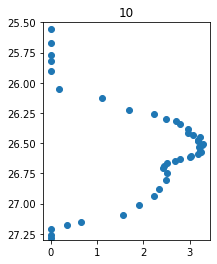

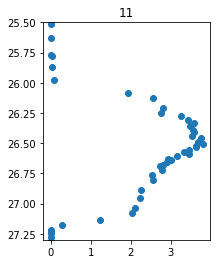

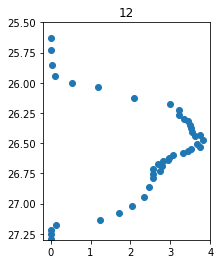

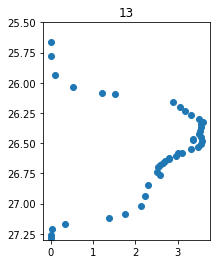

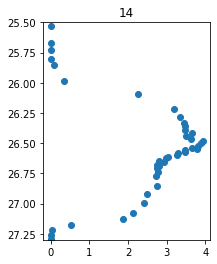

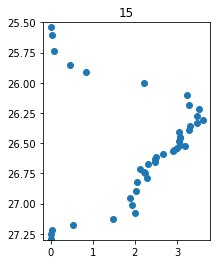

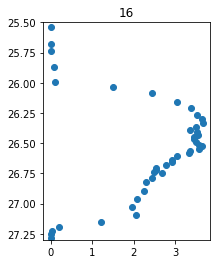

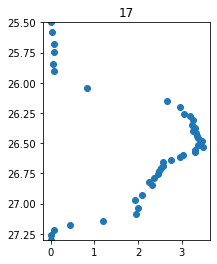

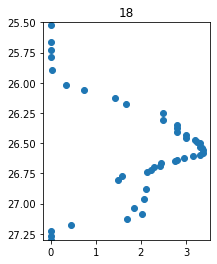

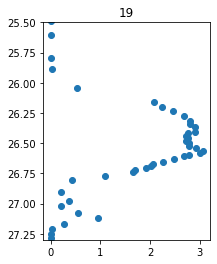

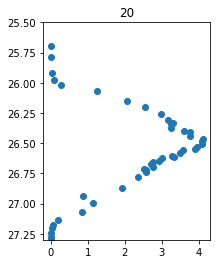

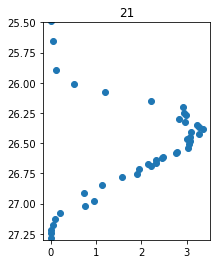

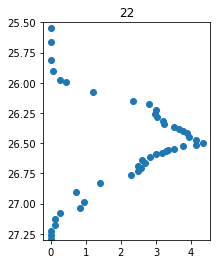

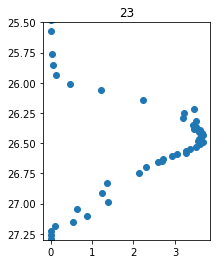

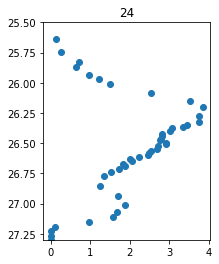

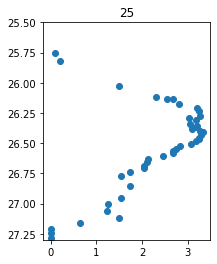

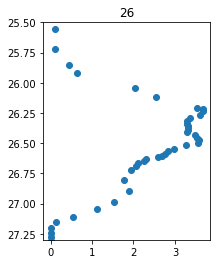

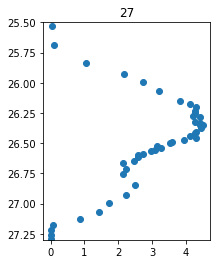

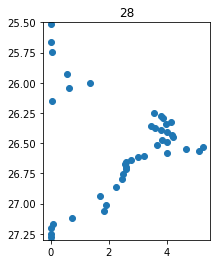

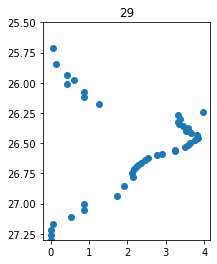

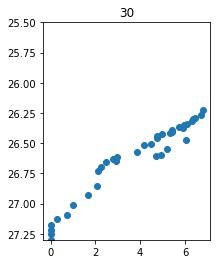

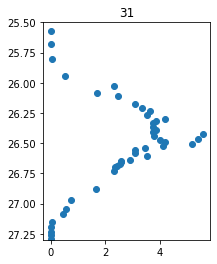

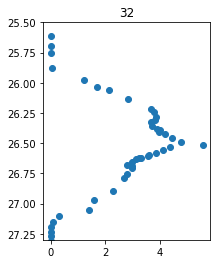

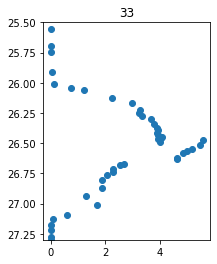

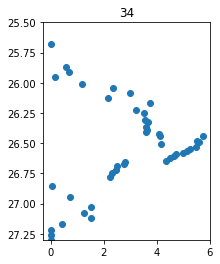

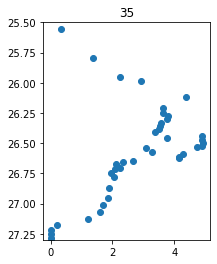

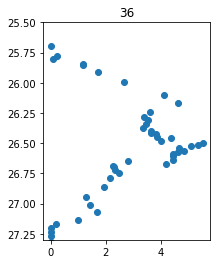

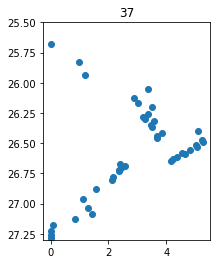

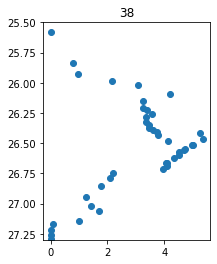

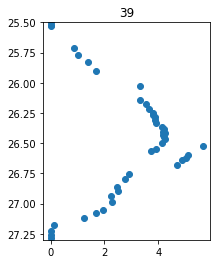

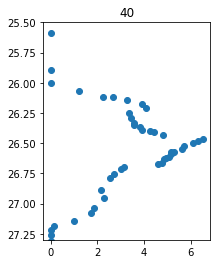

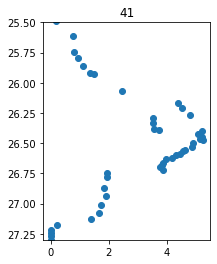

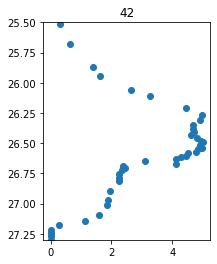

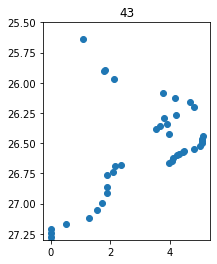

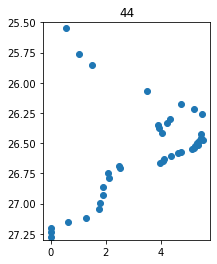

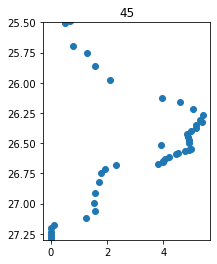

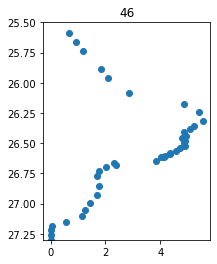

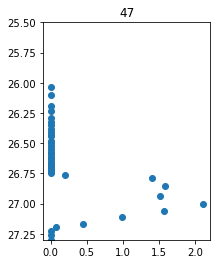

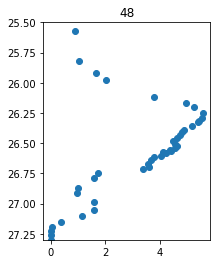

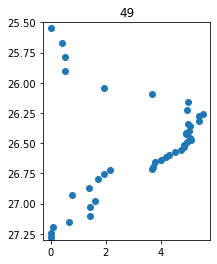

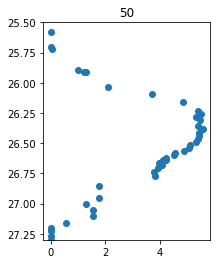

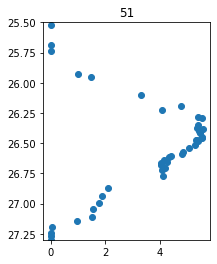

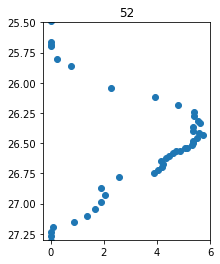

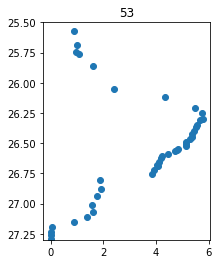

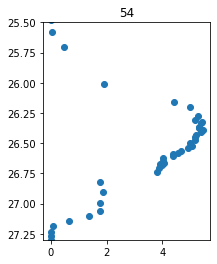

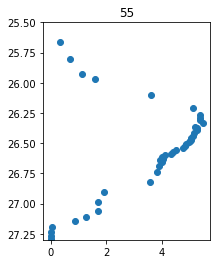

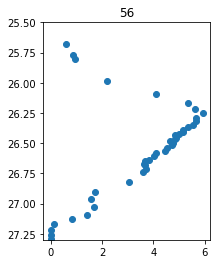

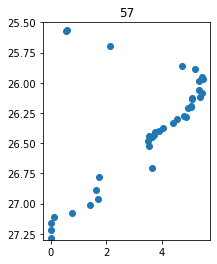

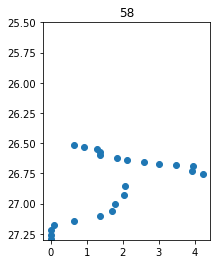

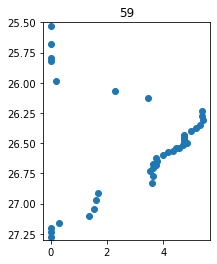

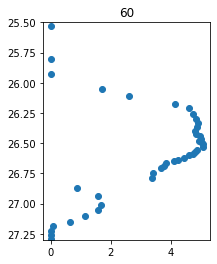

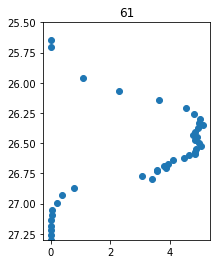

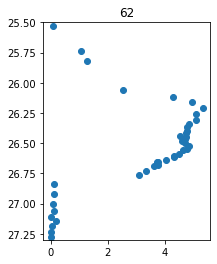

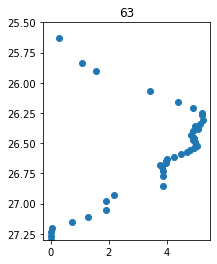

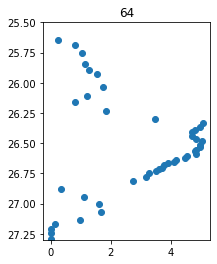

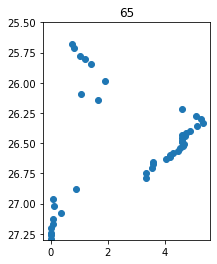

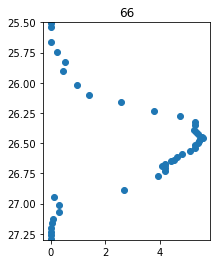

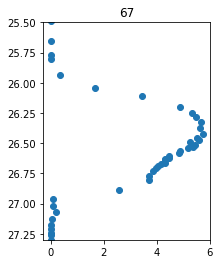

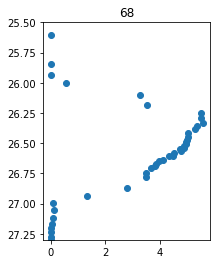

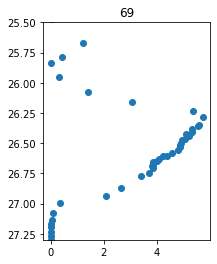

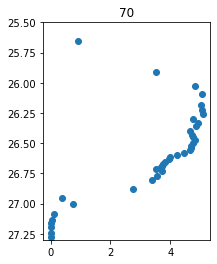

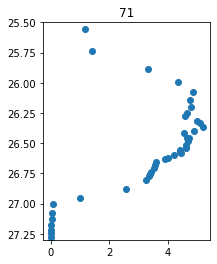

In [13]:
for s in data['station'].drop_duplicates():
    temp = data[data['station']==s]
    fig, ax = plt.subplots(1,1, figsize = (3,4))
    ax.scatter(temp.NO2,
               temp['sigma0']
              )
    ax.set_ylim([27.3,25.5])
    ax.set_title(f"{s}")